In [1]:
import numpy as np
import scipy.io as spio
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def loadMuscle():
    """
    Loading the different files and storing them in a dictionnary
    """
    
    
    HandX = spio.loadmat("dataMuscle/HandX.mat")
    HandXVel = spio.loadmat("dataMuscle/HandXVel.mat")
    HandXForce = spio.loadmat("dataMuscle/HandXForce.mat")
    
    HandY = spio.loadmat("dataMuscle/HandY.mat")
    HandYVel = spio.loadmat("dataMuscle/HandYVel.mat")
    HandYForce = spio.loadmat("dataMuscle/HandYForce.mat")
    
    Pectoralis = spio.loadmat("dataMuscle/Pectoralis.mat")
    Deltoid = spio.loadmat("dataMuscle/Deltoid.mat")
    
    extracted = spio.loadmat("dataMuscle/extracted.mat")
    descriptions = spio.loadmat("dataMuscle/descriptions.mat")
    
    
    """ 
    Creation of the first dictionnary - strMuscles
    """
    
    dictMuscles = {"HandX": HandX["HandX"],
                  "HandXVel": HandXVel["HandXVel"],
                  "HandXForce": HandXForce["HandXForce"],
                  "HandY": HandY["HandY"],
                  "HandYVel": HandYVel["HandYVel"],
                  "HandYForce": HandYForce["HandYForce"],
                  "Pectoralis": Pectoralis["Pectoralis"],
                  "Deltoid": Deltoid["Deltoid"],
                  "extracted": extracted["extracted"],
                  "descriptions": descriptions["descriptions"]}

    return dictMuscles

In [3]:
def loadNeuron():
    
    namesSignals= [
        ('time'    ),
        ('shoang'  ),
        ('elbang'  ),
        ('handxpos'),
        ('handypos'),
        ('cells'   )]
    
    dictNeurons = {}
    for targetNum in range(1,9):
            
        target = {}
            
        for trialNum in range(1,7):
            trial = {}
            for nam in namesSignals:
                key = nam
                value = spio.loadmat('dataNeuron/target'+str(targetNum)+'trial' + str(trialNum) + 'signals'+nam+'.mat')
                trial[key]=value['a']
                
            target['trial'+str(trialNum)] = trial
    
        dictNeurons['target'+str(targetNum)] = target
        
    return dictNeurons

In [4]:
def rect_kernel(t_range,width):
    """
    rect_kernel creates the rectangular kernel used to compute the firing rate

    Inputs :
    -t_range is the time span on which we want to define this kernel
    -width is the width of the rectangular kernel (in the same units as dt)

    Outputs :
    -kernel is the returned rectangular kernel
    """
    dt = t_range[1]-t_range[0]
    #print('dt: ',dt)
    n_width = int(width//dt)
    #print(n_width)
    kernel = np.zeros(len(t_range))
    centre = int(len(t_range)//2)
    for i in range(centre-int(n_width//2), centre+int(n_width//2)) :
      kernel[i] = 1/dt
    #print(len(kernel))
    return kernel

In [5]:
def firing_rate(cells,kernel):
    """
    firing rate is a function that computes the firing rate from the spike trains and a given kernel

    Inputs :
    -cells (numpy array) is the spike train we want to compute the firing rate for
    -kernel (numpy array) is the kernel used for the convolution

    Outputs :
    -firing rate (numpy array) is the resulting firing rate
    """

    firing_rate = np.convolve(cells, kernel, 'same')

    return firing_rate

In [6]:
dictMuscles = loadMuscle()
dictNeurons = loadNeuron()

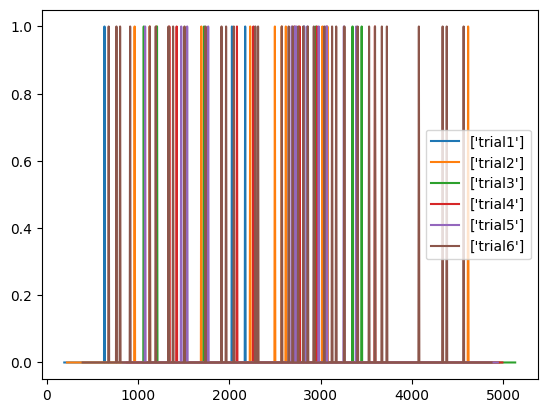

In [7]:
#%% For the neural data structure, you must calculate the firing rate and
### explore the relationship between the firing rate and the movement kinematics

# Plotting neural spikes for each trial to the first target
frequency = 200 # Hz - frequency of acquisition
T = 1/frequency # s - period of acquisition

plt.subplots()
for trial_number in range(1,7) :
    cells1 = dictNeurons['target1']['trial'+str(trial_number)]['cells']
    #print(cells1)
    # figure
    x_axis = dictNeurons['target1']['trial'+str(trial_number)]['time']
    #print(len(x_axis),len(cells1))
    plt.plot(x_axis,cells1,label=['trial'+str(trial_number)])
plt.legend()
plt.show()

In [8]:
max_length = 0
for target in range(1,9) :
    for trial_number in range(1,7) :
        time = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['time']
        if time[-1][0] > max_length :
            max_length = round(time[-1][0])

firing_rates = np.zeros((8,6,max_length)) # (rows = trials, columns = time steps) x each target
t_range = np.arange(0,max_length*T,T) # maximum time duration
kernel = rect_kernel(t_range,100e-3) # width = 0.1 [s] = 20 time steps

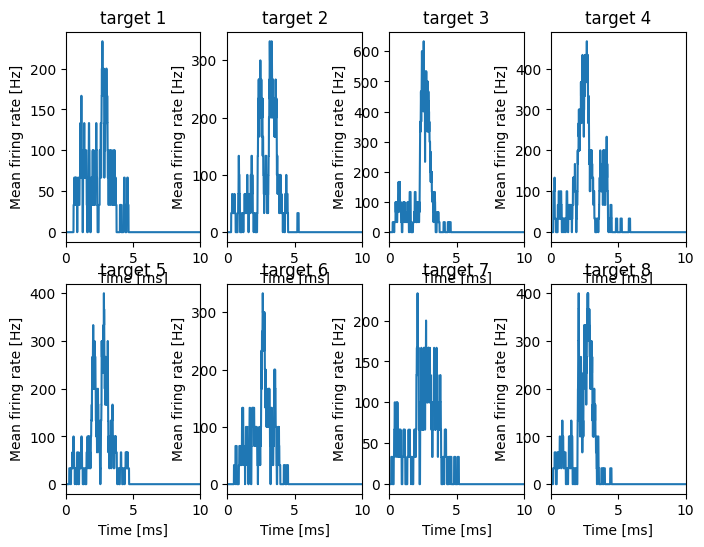

In [9]:
for target in range(1,9) :
    for trial_number in range(1,7) :
        cells = np.array(dictNeurons['target'+str(target)]['trial'+str(trial_number)]['cells'])
        # Extract the time vector to know the starting time step
        t = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['time']
        begins = int(t[0][0]*0.001/T)
        # Zero-padding on the spike train
        cells_zp = np.zeros((len(kernel),1))
        cells_zp[begins:(begins+len(cells))] = cells[:]
        # Compute firing rate
        f_rate = firing_rate(cells_zp[:,0],kernel)
        firing_rates[target-1,trial_number-1,:] = f_rate

# Plot the averaged firing rate for each target
mean_firing_rates = np.zeros((8,1,max_length))
for target in range(1,9) :
    mean_firing_rates[target-1,:,:] = np.mean(firing_rates[target-1,:,:],0)

fig, axs = plt.subplots(2,4,figsize=(8, 6))
count = -1
for target in range(1,9) :
    count += 1
    # figure
    axs[count//4][count%4].plot(t_range,mean_firing_rates[target-1,0,:])
    axs[count//4][count%4].set_xlabel("Time [ms]")
    axs[count//4][count%4].set_ylabel("Mean firing rate [Hz]")
    axs[count//4][count%4].set_xlim([0,10])
    axs[count//4][count%4].set_title('target '+str(target))
plt.show()

C:\Users\afons\AppData\Local\Temp\ipykernel_14764\3281001892.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('starting time: ', float(start_time),' seconds')
C:\Users\afons\AppData\Local\Temp\ipykernel_14764\3281001892.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('ending time: ', float(end_time),' seconds')
C:\Users\afons\AppData\Local\Temp\ipykernel_14764\3281001892.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('duration: ',float

starting time:  0.965  seconds
ending time:  21.69  seconds
duration:  20.725  seconds


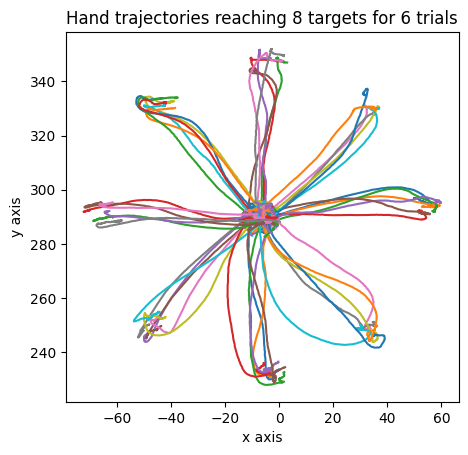

In [10]:
#%% To find the total duration for one movement: 
#print(len(dictNeurons['target1']['trial1']['time']))
start_time = dictNeurons['target1']['trial1']['time'][0]*T
print('starting time: ', float(start_time),' seconds')
end_time = dictNeurons['target1']['trial1']['time'][-1]*T
print('ending time: ', float(end_time),' seconds')
duration = end_time-start_time
print('duration: ',float(duration),' seconds')


#%% 

# Plot hand trajectiories for each target end every trial
fig, ax = plt.subplots()
for target in range(1,9) :
    for trial_number in range(1,7) :
        handxpos = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['handxpos']
        handypos = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['handypos']
        # figure
        plt.plot(handxpos,handypos,label=['trial'+str(trial_number)])
        ax.set_aspect('equal', 'box')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.title('Hand trajectories reaching 8 targets for 6 trials')
#plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

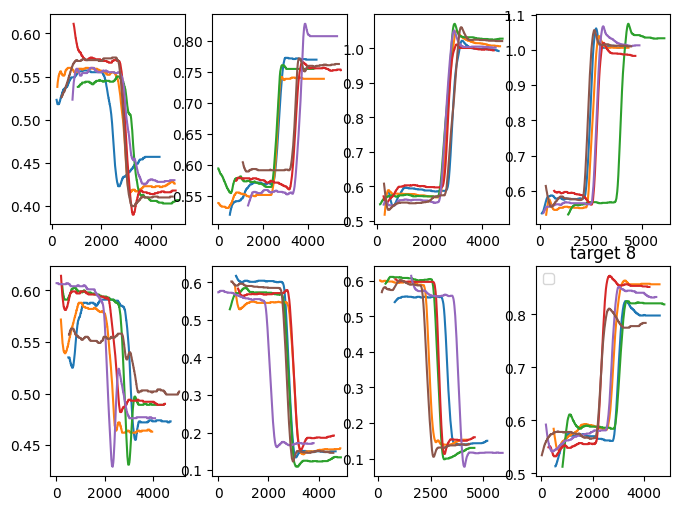

In [11]:
# Plot shoulder angles for every trial
fig, axs = plt.subplots(2,4,figsize=(8, 6))
count = -1
for target in range(1,9) :
    count += 1
    for trial_number in range(1,7) :
        shoulder_angle = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['shoang']
        time = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['time']
        # figure
        axs[count//4][count%4].plot(time,shoulder_angle)
        #plt.xlabel('time [s]')
        #plt.ylabel('angle [rad]')
    plt.title('target '+str(target))
    plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

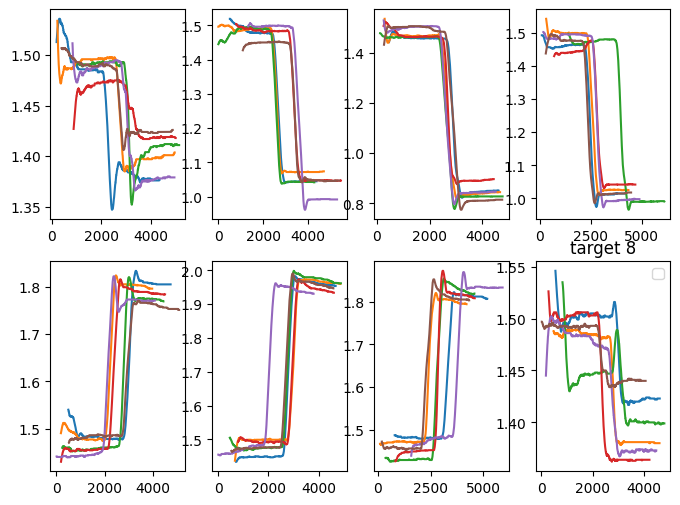

In [12]:
# Plot elbow angles for every trial
fig, axs = plt.subplots(2,4,figsize=(8, 6))
count = -1
for target in range(1,9) :
    count += 1
    for trial_number in range(1,7) :
        elbow_angle = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['elbang']
        time = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['time']
        # figure
        axs[count//4][count%4].plot(time,elbow_angle)
        #plt.xlabel('time [s]')
        #plt.ylabel('angle [rad]')
    plt.title('target '+str(target))
    plt.legend()
plt.show()

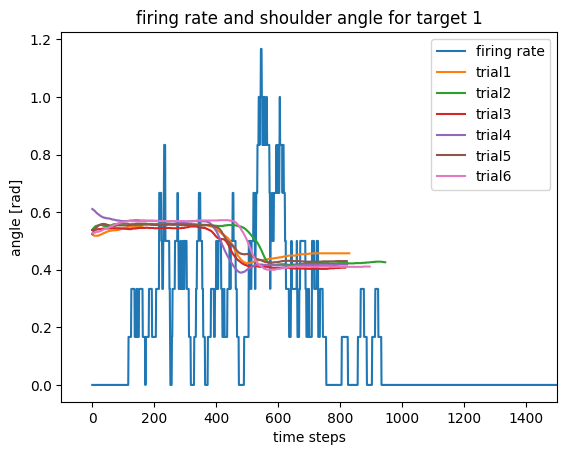

In [13]:
# Plot shoulder angles and firing rate together
fig = plt.subplots()
target = 1
plt.plot(mean_firing_rates[target-1,0,:]/200, label='firing rate')
for trial_number in range(1,7) :
    shoulder_angle = np.array(dictNeurons['target'+str(target)]['trial'+str(trial_number)]['shoang'])
    plt.plot(shoulder_angle, label='trial'+str(trial_number))
plt.legend()
plt.title('firing rate and shoulder angle for target 1')
plt.xlabel('time steps')
plt.ylabel('angle [rad]')
plt.xlim([-100,1500])
plt.show()

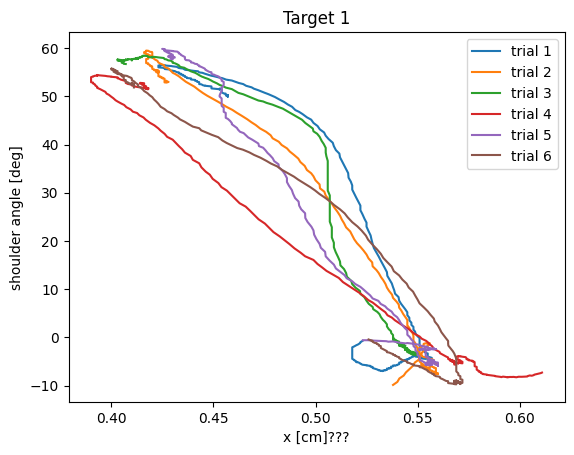

In [14]:
#%%      
# Plot x coordinate in function of shoulder angles
# target 1
fig = plt.subplots()
for trial in range(1,7) :
    x_hand = dictNeurons['target1']['trial'+str(trial)]['handxpos']
    shoang = dictNeurons['target1']['trial'+str(trial)]['shoang']
    time = dictNeurons['target1']['trial'+str(trial)]['time']
    begins = int(t[0][0]*0.001/T)
    # Zero-padding on the spike train
    x_hand_zp = np.empty((max_length,1))
    x_hand_zp[:] = np.nan
    x_hand_zp[begins:(begins+len(x_hand))] = x_hand[:]
    shoang_zp = np.empty((max_length,1))
    shoang_zp[:] = np.nan
    shoang_zp[begins:(begins+len(shoang))] = shoang[:]
    # Plots
    plt.plot(shoang_zp,x_hand_zp,label='trial '+str(trial))
plt.title('Target 1')
plt.xlabel('x [cm]???') 
plt.ylabel('shoulder angle [deg]')
plt.legend()
plt.show()

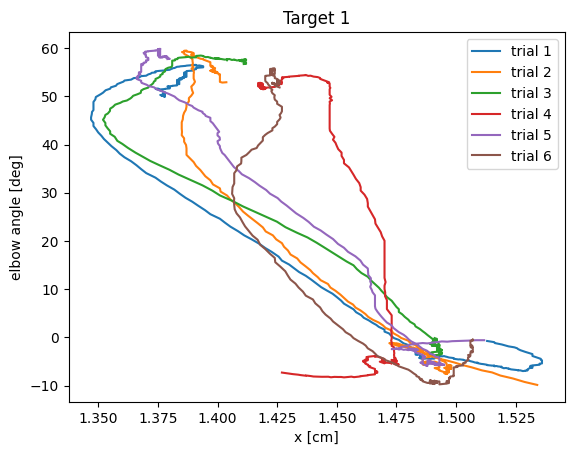

In [15]:
# Plot x coordinate in function of elbow angles
# target 1
fig = plt.subplots()
for trial in range(1,7) :
    x_hand = dictNeurons['target1']['trial'+str(trial)]['handxpos']
    elbang = dictNeurons['target1']['trial'+str(trial)]['elbang']
    time = dictNeurons['target1']['trial'+str(trial)]['time']
    begins = int(t[0][0]*0.001/T)
    # Zero-padding on the spike train
    x_hand_zp = np.empty((max_length,1))
    x_hand_zp[:] = np.nan
    x_hand_zp[begins:(begins+len(x_hand))] = x_hand[:]
    elbang_zp = np.empty((max_length,1))
    elbang_zp[:] = np.nan
    elbang_zp[begins:(begins+len(elbang))] = elbang[:]
    # Plots
    plt.plot(elbang_zp,x_hand_zp,label='trial '+str(trial))
plt.title('Target 1')
plt.xlabel('x [cm]') 
plt.ylabel('elbow angle [deg]')
plt.legend()
plt.show()

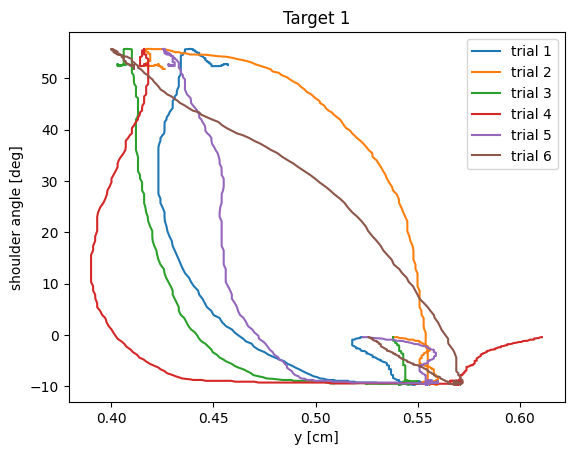

In [16]:
# Plot y coordinate in function of shoulder angles
# target 1
fig = plt.subplots()
for trial in range(1,7) :
    y_hand = dictNeurons['target1']['trial'+str(trial)]['handypos']
    shoang = dictNeurons['target1']['trial'+str(trial)]['shoang']
    time = dictNeurons['target1']['trial'+str(trial)]['time']
    begins = int(t[0][0]*0.001/T)
    # Zero-padding on the spike train
    y_hand_zp = np.empty((max_length,1))
    y_hand_zp[:] = np.nan
    y_hand_zp[begins:(begins+len(y_hand))] = y_hand[:]
    shoang_zp = np.empty((max_length,1))
    shoang_zp[:] = np.nan
    shoang_zp[begins:(begins+len(shoang))] = shoang[:]
    # Plots
    plt.plot(shoang_zp,x_hand_zp,label='trial '+str(trial))
plt.title('Target 1')
plt.xlabel('y [cm]') 
plt.ylabel('shoulder angle [deg]')
plt.legend()
plt.show()

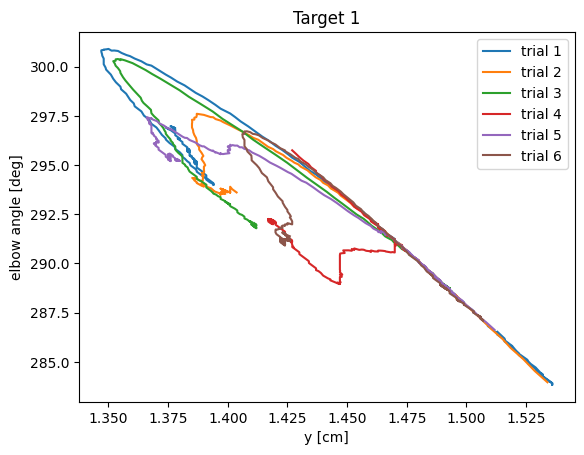

In [17]:
# Plot y coordinate in function of elbow angles
# target 1
fig = plt.subplots()
for trial in range(1,7) :
    y_hand = dictNeurons['target1']['trial'+str(trial)]['handypos']
    elbang = dictNeurons['target1']['trial'+str(trial)]['elbang']
    time = dictNeurons['target1']['trial'+str(trial)]['time']
    begins = int(t[0][0]*0.001/T)
    # Zero-padding on the spike train
    y_hand_zp = np.empty((max_length,1))
    y_hand_zp[:] = np.nan
    y_hand_zp[begins:(begins+len(y_hand))] = y_hand[:]
    elbang_zp = np.empty((max_length,1))
    elbang_zp[:] = np.nan
    elbang_zp[begins:(begins+len(elbang))] = elbang[:]
    # Plots
    plt.plot(elbang_zp,y_hand_zp,label='trial '+str(trial))
plt.title('Target 1')
plt.xlabel('y [cm]') 
plt.ylabel('elbow angle [deg]')
plt.legend()
plt.show()